In [9]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

G(N,L)

In [2]:
def gnl(N, L):

    Gnl = nx.Graph()

    nodes = np.arange(0, N)
    Gnl.add_nodes_from(nodes)

    links = []
    for i in nodes:
        for j in nodes[i+1:]:
            links.append([i,j])

    Gnl.add_edges_from(np.random.permutation(links)[:L])
    
    return Gnl


G(N,p)

In [3]:
def gnp(N, p):

    Gnp = nx.Graph()

    nodes = np.arange(0, N)
    Gnp.add_nodes_from(nodes)

    links = []
    for i in nodes:
        for j in nodes[i+1:]:
            if np.random.rand() < p:
                links.append((i,j))

    Gnp.add_edges_from(links)
    return Gnp


WS(N,k,beta)

In [4]:
def gWS(N, k, beta):

    WS = nx.Graph()

    nodes = np.arange(0, N).astype(int)

    links = np.zeros((N,k)).astype(int)
    md = k%2

    links = np.array([[node, i] for node in nodes for i in range(node - k//2 - md, node + 1 + k//2) if i != node])
    WS.add_edges_from(links%N)
    nw = []

    # jbc to mozesz zmienic:
    # 1. dodawanie i usuwanie krawedzi na biezaco
    # 2. wybor tej samej krawedzi co usuwana
    # 3. wybor samego siebie na polaczenie

    for node in nodes:
        neighbors = set(WS.neighbors(node))
        
        for ngb in neighbors:
            if np.random.rand() < beta:
                WS.remove_edge(node, ngb)
                c = node
                while c == node or c in neighbors:
                    c = np.random.choice(nodes)
                nw.append((node, c))

    WS.add_edges_from(nw)
    
    return WS


Comparison

In [5]:
N = 1000
L = 10000
p = L/(N*(N-1)/2)
k = int(2*L/N)
beta = 0.5

In [6]:
Gnl = gnl(N, L)
Gnp = gnp(N, p)
WS = gWS(N, k, beta)

Degree distribution

In [7]:
def calc_distr(G):
    degrees = []
    probs = []

    distr = {}
    for node in G.nodes():
        distr.setdefault(len(list(G.neighbors(node))), 0)
        distr[len(list(G.neighbors(node)))] += 1

    cnt = sum(distr.values())

    degrees = [i for i in distr.keys()]
    probs = [distr[i]/cnt for i in degrees]
    
    return degrees, probs

degrees = []
probs = []

d, p = calc_distr(Gnl)
degrees.append(d)
probs.append(p)

d, p = calc_distr(Gnp)
degrees.append(d)
probs.append(p)

d, p = calc_distr(WS)
degrees.append(d)
probs.append(p)

21.5
21.5
21.0


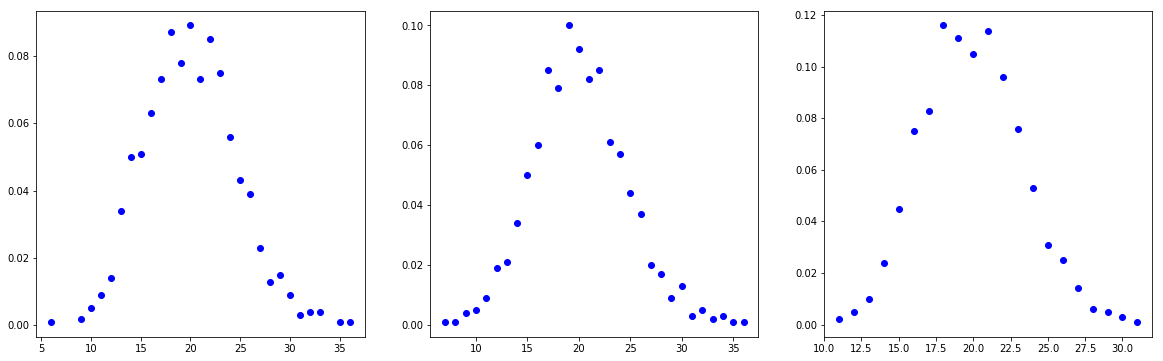

In [8]:
plt.figure(num=None,figsize=(20, 6))

plt.subplot(131)
plt.plot(degrees[0], probs[0], 'bo')
plt.subplot(132)
plt.plot(degrees[1], probs[1], 'bo')
plt.subplot(133)
plt.plot(degrees[2], probs[2], 'bo')

print(np.mean(degrees[0]))
print(np.mean(degrees[1]))
print(np.mean(degrees[2]))

Clustering

In [9]:
def clust(G):
    counts = []
    
    for node in G.nodes():
        connections = 0
        set_of_neighbors = set(G.neighbors(node))
        
        for neighbor in set_of_neighbors:
            for neighbor_of_neighbor in G.neighbors(neighbor):
                if neighbor_of_neighbor in set_of_neighbors:
                    connections += 1

        counts.append([connections, len(set_of_neighbors)])
    
    coefficients_counts = {}
    for item in counts:
        if item[1] == 1:
            coefficients_counts.setdefault(0, 0)
            coefficients_counts[0] += 1
            continue
        c = item[0]/(item[1]*(item[1]-1))
        coefficients_counts.setdefault(c, 0)
        coefficients_counts[c] += 1

    return coefficients_counts


In [10]:
c_results = [] 

for G in [Gnl, Gnp, WS]:
    coefficients_counts = clust(G)
    from more_itertools import sort_together
    x = [item[0] for item in coefficients_counts.items()]
    y = [item[1] for item in coefficients_counts.items()]
    sum_y = sum(y)
    y_d = [i/sum_y for i in y]
    x, y_d = sort_together([x,y_d])
    c_results.append([x, y, y_d])

0.026642950593207544
0.025818366225720712
0.033164177012774534


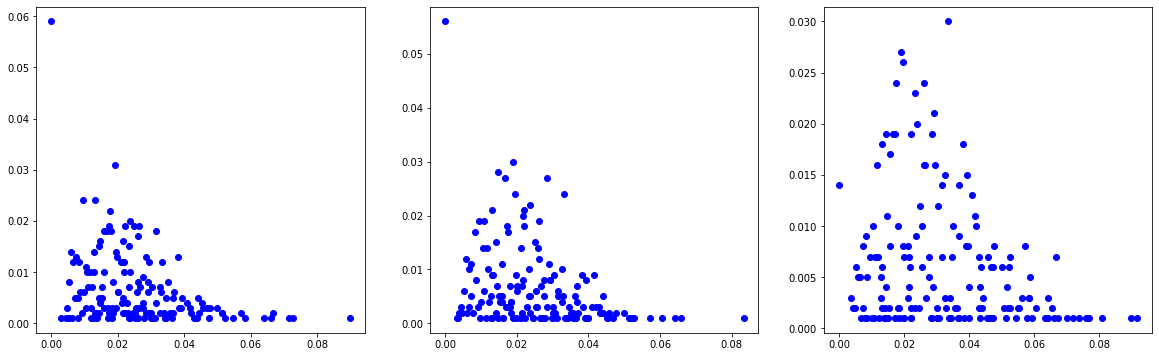

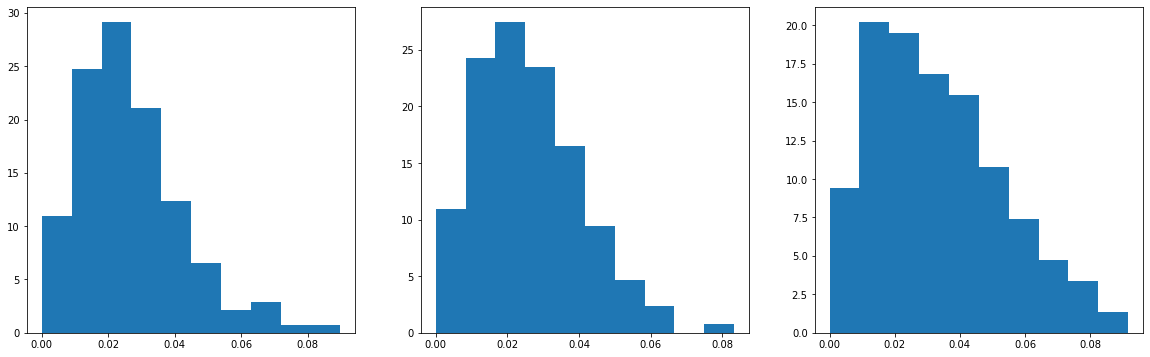

In [11]:
# print([c_results[j][1] for j in [0,1,2]])
# print(c_results[0][2])
plt.figure(num=None,figsize=(20, 6))
plt.subplot(131)
plt.plot(c_results[0][0], c_results[0][2], 'bo')
plt.subplot(132)
plt.plot(c_results[1][0], c_results[1][2], 'bo')
plt.subplot(133)
plt.plot(c_results[2][0], c_results[2][2], 'bo')

plt.figure(num=None,figsize=(20, 6))
plt.subplot(131)
plt.hist(c_results[0][0], density=True)
plt.subplot(132)
plt.hist(c_results[1][0], density=True)
plt.subplot(133)
plt.hist(c_results[2][0], density=True)


print(np.mean(c_results[0][0]))
print(np.mean(c_results[1][0]))
print(np.mean(c_results[2][0]))

Paths

In [21]:
def paths(G):
    sp = nx.shortest_path(G)

    dists = {}
    for node_paths in sp.values():
        for path in node_paths.values():
            dists.setdefault(len(path)-1,0)
            dists[len(path)-1] += 1

#     nodes = list(G.nodes())
    cnt = sum(dists.values())
    degrees = [i for i in dists.keys()]
    probs = [dists[i]/cnt for i in degrees]    
    return dists, degrees, probs

In [22]:
ps = [] 

ps.append(list(paths(Gnl)))
ps.append(list(paths(Gnp)))
ps.append(list(paths(WS)))

In [23]:
for i in range(len(ps)):
    print("diameter {}: {}".format(i, ps[i][1][-1]))
    print("average {}: {}".format(
        i, 
        sum([i*j for i,j in zip(ps[i][0].keys(), ps[i][0].values())])/sum(ps[i][0].values()))
         )
    
print(ps)

diameter 0: 4
average 0: 2.63581
diameter 1: 4
average 1: 2.637926
diameter 2: 4
average 2: 2.647444
[[{0: 1000, 1: 20000, 2: 323382, 3: 653426, 4: 2192}, [0, 1, 2, 3, 4], [0.001, 0.02, 0.323382, 0.653426, 0.002192]], [{0: 1000, 1: 19982, 2: 321422, 3: 655284, 4: 2312}, [0, 1, 2, 3, 4], [0.001, 0.019982, 0.321422, 0.655284, 0.002312]], [{0: 1000, 1: 19882, 2: 311300, 3: 666310, 4: 1508}, [0, 1, 2, 3, 4], [0.001, 0.019882, 0.3113, 0.66631, 0.001508]]]


[[0, 1, 2, 3, 4], [0, 1, 2, 3, 4], [0, 1, 2, 3, 4]]


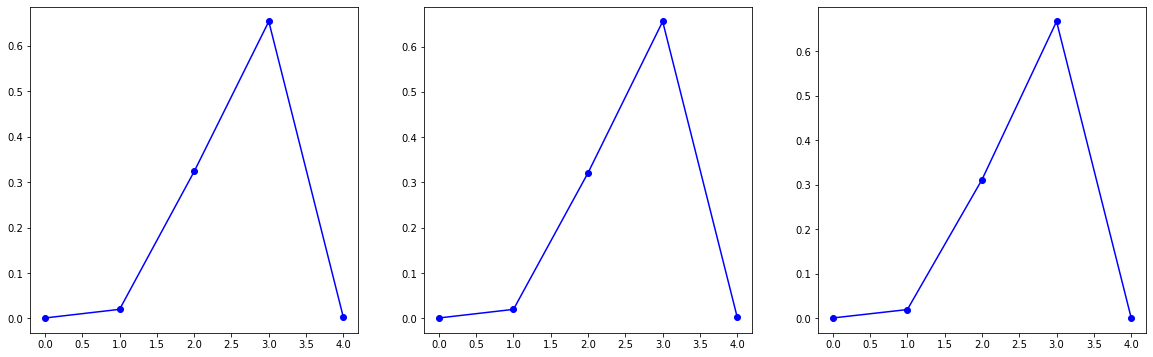

In [27]:
print( [ps[j][1] for j in [0,1,2]])
# lines added to show shape of plot in case of small number of points
plt.figure(num=None,figsize=(20, 6))
plt.subplot(131)
plt.plot(ps[0][1], ps[0][2], 'bo-')
plt.subplot(132)
plt.plot(ps[1][1], ps[1][2], 'bo-')
plt.subplot(133)
plt.plot(ps[2][1], ps[2][2], 'bo-')

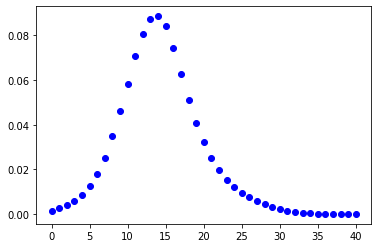

In [25]:
ps1 = list(paths(gWS(1000, 2, 0.5)))
plt.plot(ps1[1], ps1[2], 'bo')